In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import os

import numpy as np
import pandas as pd

import torch
import torchvision
from glob import glob
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset
from torchvision.utils import make_grid

from nets import SimpleSegmentationNet
from data import CityscapesDataset
from labels import labels
from unet import UNet

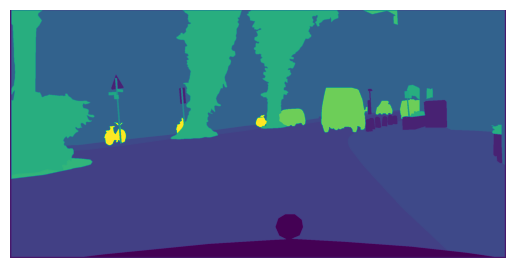

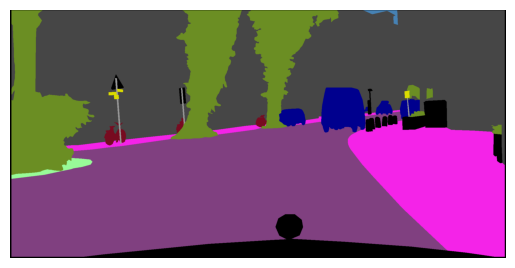

In [3]:
def view_cityscapes_image(dataset_dir, image_file):
    """
    View an image from the Cityscapes dataset.

    :param dataset_dir: Directory where the Cityscapes dataset is stored.
    :param image_file: The name of the image file to be displayed.
    """
    image_path = os.path.join(dataset_dir, image_file)

    # Check if the file exists
    if not os.path.exists(image_path):
        print(f"Image file {image_path} not found.")
        return

    # Load and display the image
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# Example usage
dataset_directory = '/cluster/projects/vc/data/ad/open/Cityscapes/gtFine_trainvaltest/gtFine/train/bremen'
image_filename1 = 'bremen_000000_000019_gtFine_labelIds.png'
image_filename2 = 'bremen_000000_000019_gtFine_color.png'

view_cityscapes_image(dataset_directory, image_filename1)
view_cityscapes_image(dataset_directory, image_filename2)

In [4]:
    train_seg_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/gtFine_trainvaltest/gtFine/train/*/*labelIds.png'))
    train_img_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/*/*.png'))

    val_seg_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/gtFine_trainvaltest/gtFine/val/*/*labelIds.png'))
    val_img_path = sorted(glob('/cluster/projects/vc/data/ad/open/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val/*/*.png'))

In [5]:
class_counts = {i: 0 for i in range(-1, 34)}
total_images = 0

for path in train_seg_path:
    if os.path.isfile(path):
        total_images += 1
        seg_image = Image.open(path)
        seg_array = np.array(seg_image)

        unique_classes = np.unique(seg_array)
        for cls in unique_classes:
            if -1 <= cls <= 33:
                class_counts[cls] += 1

In [6]:
# Present classes in the dataset
present_classes = [cls for cls, count in class_counts.items() if count > 0]
print(sorted(present_classes))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [8]:
## Amount of the different classes relative to the other

# Calculate the total number of instances across all classes
total_instances = sum(class_counts.values())

# Calculate the relative amount of each class and store the results in a new dictionary
relative_amounts = {cls: count / total_instances for cls, count in class_counts.items() if count > 0}

# Print the classes and their relative amounts sorted by class
for cls in sorted(relative_amounts):
    print(f"Class {cls}: {relative_amounts[cls]:.2%}")

Class 0: 1.68%
Class 1: 6.02%
Class 2: 2.22%
Class 3: 6.02%
Class 4: 5.96%
Class 5: 2.76%
Class 6: 2.17%
Class 7: 5.93%
Class 8: 5.69%
Class 9: 1.46%
Class 10: 0.20%
Class 11: 5.93%
Class 12: 1.96%
Class 13: 2.62%
Class 14: 0.04%
Class 15: 0.47%
Class 16: 0.05%
Class 17: 5.97%
Class 18: 0.45%
Class 19: 3.35%
Class 20: 5.68%
Class 21: 5.85%
Class 22: 3.35%
Class 23: 5.43%
Class 24: 4.74%
Class 25: 2.07%
Class 26: 5.73%
Class 27: 0.73%
Class 28: 0.55%
Class 29: 0.12%
Class 30: 0.15%
Class 31: 0.29%
Class 32: 1.04%
Class 33: 3.33%


(0.060176382539746755, 0.060176382539746755, 0.05965047129738258, 0.0595695618754804, 0.0593470609652494, 0.0593470609652494, 0.05847728467980096, 0.0572838707067438, 0.056859096241757355, 0.05679841417533072, 0.05433067680731421, 0.04739269387920223, 0.033536955378453824, 0.03345604595655164, 0.03329422711274728, 0.0276103402241191, 0.026214652696306486, 0.02220963631214855, 0.021703952425259923, 0.020692584651482666)


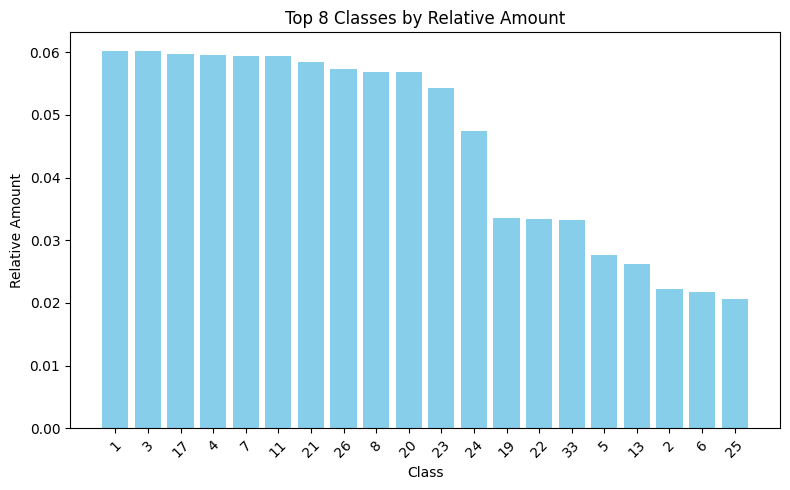

In [35]:
# Sort the items by their relative amount and select the top 8
top_items = sorted(relative_amounts.items(), key=lambda x: x[1], reverse=True)[:20]
top_labels, top_sizes = zip(*top_items)
print(top_sizes)

# Convert numeric labels to strings
top_labels_str = [str(label) for label in top_labels]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(top_labels_str, top_sizes, color='skyblue')
plt.title('Top 8 Classes by Relative Amount')
plt.xlabel('Class')
plt.ylabel('Relative Amount')
plt.xticks(rotation=45)  # Rotate class labels for better readability

# Display the plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


In [31]:
from labels import mapping

lst_labels = [key for key, value in mapping.items() if value > 0]

print(sorted(lst_labels))

print(sorted(top_labels))


[7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
[1, 2, 3, 4, 5, 6, 7, 8, 11, 13, 17, 19, 20, 21, 22, 23, 24, 26, 33]


In [32]:
# Average number of different classes per image 
average_classes_per_image = sum(class_counts.values()) / total_images
print(average_classes_per_image)

16.61781512605042
